# Data pre-processing

In [ ]:
# Import the data
# Using the following command, need to download and initialize google cloud sdk first
'''mkdir Hurricane_Harvey 
 mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
 gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
 gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

mkdir Hurricane_Harvey_Synthetic 
 mkdir Hurricane_Harvey_Synthetic/rasters Hurricane_Harvey_Synthetic/vectors 
 gsutil -m cp -n -r gs://geoengine-dataset-houston-uav-synthetic/rasters/raw Hurricane_Harvey_Synthetic/rasters/ 
 gsutil -m cp -n -r gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/ Hurricane_Harvey_Synthetic/vectors/
'''


In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the data dictionary

mask_datadir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"
image_datadir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/rasters/raw"


In [ ]:
# Import the libraries
import os
import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss
from torch import optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm import tqdm

from PIL import Image
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

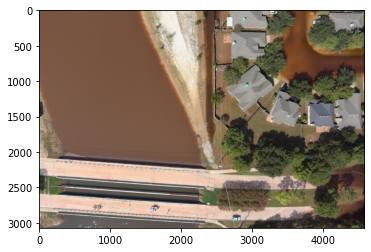

In [ ]:
# Observe the images and masks
import cv2
import matplotlib.pyplot as plt
import numpy as np

name = 6695 # The picture belongs to the "boat" class

# original RGB image
image = plt.imread(f'/content/drive/MyDrive/Hurricane_Harvey/rasters/raw/{name}.tif')

# binary mask
mask = plt.imread(f'/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/{name}.png')

# Create a 3 channel image with mask and original image
overlay = np.zeros_like(image)
overlay[:,:,0] = mask*255
overlay = overlay + image

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Display the mask on top of the image with 50% transparency
ax.imshow(overlay)

# Show the plot
plt.show()

You can see from the picture, in some classes, the mask is not even working at all, which means the label quality is poor and need deeper architecture. 

In [ ]:
# Extract the training file names
#metatraindir = "/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv"
metatraindir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv"
labeled_listpd = pd.read_csv(metatraindir)
labeled_list = labeled_listpd["image:01"].map(lambda x:x.split("/")[-1]).tolist()
arr = np.array(labeled_list)
labeled_list = np.unique(arr)
# Optional: Remove some bad training set as their mask is badly recognized
abandon_classes = [9,11,16,17,20,25]

Trees / Shrubs                             9644
Grass                                      4403
Property Roof                              1934
Vehicle                                    1697
Window                                      892
Chimney                                     821
Secondary Structure                         457
Parking Area                                427
Swimming Pool                               359
Power Lines & Cables                        287
Flooded                                     277
Road / Highway                              266
Street Light                                237
Dense Vegetation / Forest                   195
Garbage Bins                                153
Water Body                                   82
Satellite Antenna                            74
Trampoline                                   72
Solar Panels                                 52
Parking Area - Commercial                    45
Under Construction / In Progress Status 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

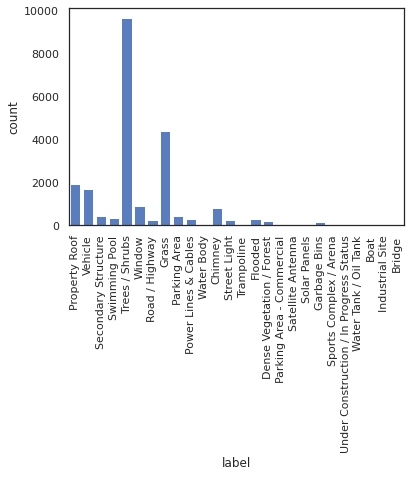

In [ ]:
# Check the distribution of labels
import seaborn as sns
class_counts = labeled_listpd['label'].value_counts()
print(class_counts)
sns.countplot(x='label', data=labeled_listpd, color="b")
plt.xticks(rotation=90)

We can see from the distribution, the variables are imbalanced. One solution is to remove those minor classes, another alternative method is to use GAN and synthetic dataset to generate compensate dataset. Considering the time and resource limit, we didn't do it here.

In [ ]:
# The codes below require large computing resources, recommend the school to offer GPU resource next time
# This time we bought google colab pro, which is very useful

# Data augmentation and resizing
def shiftrgb(im):
    # Shift the RGB values
    rgb_shift = (10, 20, 30) # shift values for each channel
    im[:, :, 0] += rgb_shift[0] # R channel
    im[:, :, 1] += rgb_shift[1] # G channel
    im[:, :, 2] += rgb_shift[2] # B channel

    # Clipping the values of image array after shift
    im = np.clip(im, 0, 255).astype("uint8")
    return im

from torchvision.transforms import Compose, ToPILImage, ToTensor


# Tensor gauss noise pipeline

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 25
    out = img*255 + sigma * torch.randn_like(img)
    out = out.numpy().astype('uint8')
    out = out.transpose(1,2,0)

    return out


gauss_noise = Compose([
    ToTensor(),
    gauss_noise_tensor
])

def datatran(mask_datadir,image_datadir,labeled_list):
    img_size = 512, 512  #1024 When I tried to use 1024, the RAM exploded. 
    mask_size = 512, 512

    seed = 10 # To make sure the image and mask are cropped in the same way

    from tqdm import tqdm
    

    #Image transformations, adapted to the transformations originally used to train ResNet
    transform_img = transforms.Compose([transforms.ToTensor()])  #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    #The data normalization is written in the deeplabv3+ model, thus muted here
    #When training Unet model, we need it
    
    #Transformations for training masks
    transform_mask = transforms.Compose([transforms.ToTensor()])

    #GaussianBlur
    transform_blur = transforms.Compose([transforms.GaussianBlur(kernel_size=(51,51),sigma=(1, 2))])
    
    #RandomCrop
    transform_crop = transforms.Compose([
    transforms.RandomCrop(size=(1500,2000), padding=10),])

    #Brightness and contrast
    transform_bc = transforms.Compose([transforms.ColorJitter(brightness=(0.5, 2), contrast=(1.5, 3))])

    #Define directories
    directory_names = [mask_datadir,image_datadir] 
    dataset = []

    #Number of classes
    n_classes = 27 # the classes are 26, but 0 for background
    
    #Iterate through every directory
    for name in directory_names:
      directory = os.fsencode(name)
      list_tensors = []
      #Iterate every file 
      for file in tqdm(sorted(os.listdir(directory))):
        filename = os.fsdecode(file)
        #Pre-processing for training masks
        if name == mask_datadir:
          #Load image
          im = cv2.imread(name + '/' + filename, cv2.IMREAD_GRAYSCALE)
          #Convert to np array
          im = np.array(im, dtype='i')
          #Crop for data augmentation
          im_copy = im.copy()
          torch.random.manual_seed(seed)
          im_crop = np.array(transform_crop(Image.fromarray(im_copy)))
          im_crop = cv2.resize(im_crop, dsize= mask_size,interpolation = cv2.INTER_NEAREST)
          #Resize for training
          im = cv2.resize(im, dsize= mask_size,interpolation = cv2.INTER_NEAREST)
          #Apply transformations to generate several versions of patch (RGB shift & flipping & rotations)
          #The processing of masks should be compatible with the processing for images
          im_list = [im, im, im, im, im, im_crop, np.flip(im,axis=0).copy(), np.rot90(im, k=1, axes=(0, 1)).copy(), np.rot90(im, k=3, axes=(0, 1)).copy()]
          #Iterate through different versions
          for im in im_list:
            tensor_img = transform_mask(im)
            tensor_img = tensor_img.squeeze()
            #Append tensor to list
            list_tensors.append(tensor_img.type(torch.FloatTensor))
              
        #Pre-processing for images
        elif filename in labeled_list:
          #Load image
          im = cv2.imread(name + '/' + filename)
          #Convert to np array
          im = np.array(im)
          #Copy the image to make sure the original one unchanged
          im_copy = im.copy()
          torch.random.manual_seed(seed)
          im_crop = np.array(transform_crop(Image.fromarray(im_copy)))
          im_crop = cv2.resize(im_crop, dsize= img_size,interpolation = cv2.INTER_NEAREST)
          #Resize to meet the input format
          im = cv2.resize(im, dsize= img_size,interpolation = cv2.INTER_NEAREST)
          im_copy = im.copy()
          im_noise = gauss_noise(Image.fromarray(im_copy))
          im_copy = im.copy()
          im_blur = np.array(transform_blur(Image.fromarray(im_copy)))
          im_copy = im.copy()
          im_bc = np.array(transform_bc(Image.fromarray(im_copy)))
          im_copy = im.copy()
          #Apply transformations to generate several versions of patch (RGBshift & flipping & rotations)
          im_list = [im, shiftrgb(im_copy), im_noise, im_blur, im_bc, im_crop, np.flip(im,axis=0).copy(), np.rot90(im, k=1, axes=(0, 1)).copy(),np.rot90(im, k=3, axes=(0, 1)).copy()]
          #Iterate through different versions
          for im in im_list:
            #Apply image transformations
            tensor_img = transform_img(im.astype(np.float32))
            #Append tensor to list
            list_tensors.append(tensor_img.type(torch.FloatTensor))
      #Append list of tensors as element in dataset
      dataset.append(list_tensors)
    return dataset

In [ ]:
dataset = datatran(mask_datadir,image_datadir,labeled_list)

  0%|          | 0/299 [00:00<?, ?it/s]


In [ ]:
print(np.array(dataset)[0][0].shape)

torch.Size([512, 512])


<ipython-input-52-dbc0ec499bd8>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.array(dataset)[0][0].shape)
<ipython-input-52-dbc0ec499bd8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(dataset)[0][0].shape)


In [ ]:
# Save the mask for DeepLabV3 plus training
count = 0
for i in dataset[0]:
    count+=1
    img = i.numpy()
    img = Image.fromarray(img.astype(np.uint8))
    name = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/mask_processed/"
    #Save mask as image
    img.save(name+str(count)+'.png')

In [ ]:
print(count)

2691


In [ ]:
# Save the images for DeepLabV3 plus training
count = 0
for i in dataset[0]:
    count+=1
    img = i.numpy().transpose(1,2,0)
    img = Image.fromarray(img.astype(np.uint8),'RGB')
    name = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/image_processed/"
    #Save mask as image
    img.save(name+str(count)+'.jpg')

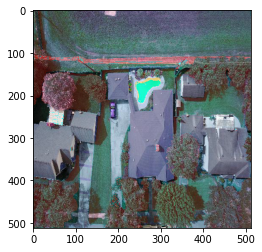

In [ ]:
# Check the image and mask matched after the preprocessing
import cv2
import matplotlib.pyplot as plt
import numpy as np

name = 7 

# original RGB image
image = plt.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/image_processed/{name}.jpg')
# binary mask
mask = plt.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/mask_processed/{name}.png')

# Create a 3 channel image with mask and original image
overlay = np.zeros_like(image)
overlay[:,:,0] = mask*255/26*255
overlay = overlay + image

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Display the mask on top of the image with 50% transparency
ax.imshow(overlay)

# Show the plot
plt.show()

In [ ]:
# Optional: To remove the bad masks
def removeabandon(mask,abandon_classes):

    # Create a boolean mask for the classes to be deleted
    delete_mask = np.isin(mask, abandon_classes)

    # Use logical indexing to delete the specified classes from the mask
    mask[delete_mask] = 0
    return mask

In [ ]:
# For Unet training: Pair the images and masks
def trainbatch(dataset):
    from tqdm import tqdm
    #Load training masks from dataset
    train_masks = dataset[0]
    #Load training images from dataset
    train_images = dataset[1]

    train_batch = []

    #Append image + mask paris to list
    for i in tqdm(range(len(train_images))):
      pair = []
      pair.append(train_images[i])
      pair.append(train_masks[i])
      train_batch.append(pair)
    return train_batch

In [ ]:
# For Unet training: Split the training set and validation set
def valsplit(train_batch):
    #Define train/validation split
    validation_split = 0.2
    shuffle_dataset = 1
    random_seed = 1

    # Compute the size of the dataset and the indexes
    dataset_size = len(train_batch)
    indices = list(range(dataset_size))

    #Get the number of validation files based on the split and the dataset size
    split = int(np.floor(validation_split * dataset_size))

    #Train_indices and val_indices
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    #Define batch size
    bs = 3 # Probably too small, larger batches can reflect the whole dataset better

    #Define train and validation dataloaders based on the random sampling
    train_dataloader = DataLoader(train_batch, batch_size=bs,sampler=train_sampler,num_workers=2, pin_memory=True)
    val_dataloader = DataLoader(train_batch, batch_size=bs, sampler=valid_sampler,num_workers=2, pin_memory=True) 
    return train_dataloader,val_dataloader

In [ ]:
# Run the functions to create training/validation data set for UNet training
dataset = datatran(mask_datadir,image_datadir,labeled_list)
data_batch = trainbatch(dataset)
train_dataloader, val_dataloader = valsplit(data_batch)

# Model Training

In [ ]:
#UNet architecture with pre-trained ResNet18 Encoder
#based on https://github.com/usuyama/pytorch-unet

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from torch.optim.lr_scheduler import StepLR
#Define model
n_classes = 27
#model = ResNetUNet(n_classes)
# DeepLab v3+ (built on top of a pre-trained ResNet50 architecture)
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

# Using inherent deeplabv3 model didn't fit well too, need to adjust the architecture
#model = models.segmentation.deeplabv3_resnet101(pretrained=True,progress=True)
#model.classifier = DeepLabHead(2048, n_classes)

#Define loss criterion
criterion = CrossEntropyLoss()

#Specify number of epochs
epochs = 15

#Define optimizer (should be defined after CUDA is activated)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.4)

#Check hardware and enable CUDA if preferred, otherwise uses CPU.
enable_cuda = True

if torch.cuda.is_available() & enable_cuda:
    model = model.cuda()
    criterion = CrossEntropyLoss().cuda()
    device = torch.device("cuda")
    print("CUDA enabled, using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

#Define save location for model progress etc.
save_folder="/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey"

#Function for saving accuracy and loss
def write_results(save_folder, epoch, train_loss, val_loss):
    ff=open('./{}/progress.txt'.format("./"),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CUDA enabled, using GPU


  1%|          | 3/399 [00:00<01:01,  6.39it/s]

Train (epoch 1/20) [0/399 (0%)]	Loss: 21.263098


100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


TRAIN_LOSS:  2.320
VAL_LOSS:  1.494


  1%|          | 3/399 [00:00<01:02,  6.37it/s]

Train (epoch 2/20) [0/399 (0%)]	Loss: 1.312861


100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


TRAIN_LOSS:  1.264
VAL_LOSS:  1.107


  1%|          | 3/399 [00:00<01:03,  6.28it/s]

Train (epoch 3/20) [0/399 (0%)]	Loss: 0.873287


100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


TRAIN_LOSS:  0.990
VAL_LOSS:  0.960


  1%|          | 3/399 [00:00<01:02,  6.33it/s]

Train (epoch 4/20) [0/399 (0%)]	Loss: 0.733965


100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


TRAIN_LOSS:  0.872
VAL_LOSS:  0.838


  1%|          | 3/399 [00:00<01:02,  6.35it/s]

Train (epoch 5/20) [0/399 (0%)]	Loss: 1.061053


100%|██████████| 100/100 [00:02<00:00, 37.82it/s]


TRAIN_LOSS:  0.743
VAL_LOSS:  0.785


  1%|          | 3/399 [00:00<01:02,  6.29it/s]

Train (epoch 6/20) [0/399 (0%)]	Loss: 0.693593


100%|██████████| 100/100 [00:02<00:00, 39.24it/s]


TRAIN_LOSS:  0.609
VAL_LOSS:  0.689


  1%|          | 3/399 [00:00<01:00,  6.52it/s]

Train (epoch 7/20) [0/399 (0%)]	Loss: 0.420214


100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


TRAIN_LOSS:  0.542
VAL_LOSS:  0.708


  1%|          | 3/399 [00:00<01:04,  6.16it/s]

Train (epoch 8/20) [0/399 (0%)]	Loss: 0.414682


100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


TRAIN_LOSS:  0.503
VAL_LOSS:  0.718


  1%|          | 3/399 [00:00<01:03,  6.21it/s]

Train (epoch 9/20) [0/399 (0%)]	Loss: 0.393178


100%|██████████| 100/100 [00:02<00:00, 39.75it/s]


TRAIN_LOSS:  0.467
VAL_LOSS:  0.691


  1%|          | 3/399 [00:00<01:00,  6.54it/s]

Train (epoch 10/20) [0/399 (0%)]	Loss: 0.443990


100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


TRAIN_LOSS:  0.442
VAL_LOSS:  0.685


  1%|          | 3/399 [00:00<01:03,  6.21it/s]

Train (epoch 11/20) [0/399 (0%)]	Loss: 0.343895


100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


TRAIN_LOSS:  0.402
VAL_LOSS:  0.682


  1%|          | 3/399 [00:00<01:02,  6.29it/s]

Train (epoch 12/20) [0/399 (0%)]	Loss: 0.251359


100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


TRAIN_LOSS:  0.384
VAL_LOSS:  0.670


  1%|          | 3/399 [00:00<01:04,  6.15it/s]

Train (epoch 13/20) [0/399 (0%)]	Loss: 0.377117


100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


TRAIN_LOSS:  0.372
VAL_LOSS:  0.695


  1%|          | 3/399 [00:00<01:02,  6.38it/s]

Train (epoch 14/20) [0/399 (0%)]	Loss: 0.246021


100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


TRAIN_LOSS:  0.360
VAL_LOSS:  0.709


  1%|          | 3/399 [00:00<01:00,  6.53it/s]

Train (epoch 15/20) [0/399 (0%)]	Loss: 0.418480


100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


TRAIN_LOSS:  0.348
VAL_LOSS:  0.708


  1%|          | 3/399 [00:00<01:01,  6.41it/s]

Train (epoch 16/20) [0/399 (0%)]	Loss: 0.285888


100%|██████████| 100/100 [00:02<00:00, 38.16it/s]


TRAIN_LOSS:  0.337
VAL_LOSS:  0.712


  1%|          | 3/399 [00:00<01:01,  6.39it/s]

Train (epoch 17/20) [0/399 (0%)]	Loss: 0.209988


100%|██████████| 100/100 [00:02<00:00, 38.93it/s]


TRAIN_LOSS:  0.330
VAL_LOSS:  0.729


  1%|          | 3/399 [00:00<01:03,  6.19it/s]

Train (epoch 18/20) [0/399 (0%)]	Loss: 0.345375


100%|██████████| 100/100 [00:02<00:00, 39.07it/s]


TRAIN_LOSS:  0.327
VAL_LOSS:  0.729


  1%|          | 3/399 [00:00<01:00,  6.54it/s]

Train (epoch 19/20) [0/399 (0%)]	Loss: 0.214265


100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


TRAIN_LOSS:  0.323
VAL_LOSS:  0.723


  1%|          | 3/399 [00:00<01:02,  6.32it/s]

Train (epoch 20/20) [0/399 (0%)]	Loss: 0.255169


100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


TRAIN_LOSS:  0.317
VAL_LOSS:  0.726


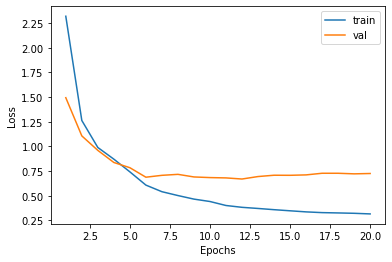

In [ ]:
#Unet, this model doesn't performs well
total_train_losses = []
total_val_losses = []


for epoch in range(1,epochs+1):
    
    #Training
    model.train()
    train_losses = []

    #Iterate through training batches
    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        
        optimizer.zero_grad()

        #Compute output
        outputs = model(img_batch.float())#['out']
        
        #Compute loss
        loss=criterion(outputs, lbl_batch.long())  
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % 500 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    scheduler.step()

    #Validation
    model.eval()
    val_losses = []


    #Iterate through validation batches
    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)

        #Compute output
        outputs=model(img_batch.float())#['out']
        
        #Compute loss
        loss=criterion(outputs, lbl_batch.long())

        val_losses.append(loss.item())


    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean)
    
    write_results(save_folder, epoch, train_loss_mean, val_loss_mean)

    #Save model
    torch.save(model, save_folder + '/model_{}.pt'.format(epoch))

#Plot graph
plt.plot(list(range(epochs+1))[1:], total_train_losses)
plt.plot(list(range(epochs+1))[1:], total_val_losses)
plt.legend(['train', 'val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Save the training process
torch.save(model, save_folder+'/modelsatellite.pt')

In [ ]:
# Load the best result model
save_folder="/content/drive/MyDrive/Hurricane_Harvey"
# Reread the previous training process
model = torch.load(save_folder+'/dmodel_11.pt')

In [ ]:
#UNet: Define test image size
size= 512, 512
#size= 1024, 512

#Image transformations, adapted to the transformations originally used to train ResNet
transform = transforms.Compose([transforms.ToTensor()]) # ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

#Iterate through every directory
directory = os.fsencode(image_datadir)
list_tensors = []
#Iterate through every file 
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  if filename in labeled_list:
    pass
  else:
    #Load image
    im = cv2.imread(image_datadir + '/' + filename)
    #Convert image to np array
    im = np.array(im)
    #Resize
    im = cv2.resize(im, dsize= size,interpolation = cv2.INTER_NEAREST)
    #Apply image transformations
    tensor_img = transform(im)
    #Append tensor to list with filename
    list_tensors.append((tensor_img,filename))


In [ ]:
print(np.array(list_tensors[0][0]).shape)


(3, 512, 512)


In [ ]:
# Save the test images for deeplabV3+ model
for img,name in list_tensors:
    img = img.numpy().transpose(1,2,0)
    img = img*255
    img = Image.fromarray(img.astype(np.uint8),'RGB')
    path = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_processed/"
    #Save mask as image
    img.save(path+name[:-4]+'.jpg')

In [ ]:
#Load test tensors into dataloder with batchsize 2
test_dataloader = DataLoader(list_tensors, batch_size=2, shuffle=True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey

/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey


In [ ]:
# DeeplabV3+
import time
import cv2
import numpy as np
from PIL import Image
from deeplab import DeeplabV3

if __name__ == "__main__":
    # We predefined the color map(classes from 0 to 26) in deeplab.py
    deeplab = DeeplabV3()
    # Here we rewrite the prediction codes to make it iterable
    mode = "predict"
    # The following parameters can help show the prediction result, doesn't matter here
    count           = False
    name_classes    = ["background","Property Roof","Secondary Structure","Swimming Pool",\
                       "Vehicle","Grass","Trees / Shrubs","Solar Panels","Chimney",\
                       "Street Light","Window","Satellite Antenna","Garbage Bins",\
                       "Trampoline","Road / Highway","Under Construction / In Progress Status",\
                       "Power Lines & Cables","Bridge","Water Tank / Oil Tank","Parking Area - Commercial",\
                       "Sports Complex / Arena","Industrial Site","Dense Vegetation / Forest",\
                       "Water Body","Flooded","Boat","Parking Area"]
    # Same as above
    test_interval = 100
    fps_image_path  = ""
    # Not used
    simplify        = False
    onnx_save_path  = "model_data/models.onnx"

    if mode == "predict":
        import os
        from tqdm import tqdm
        # Iterate through the test images and save the results in the drive
        # Attention, the shape of image here is (3,512,512) with values like (0,0,0) to indicate the classes 
        img_names = os.listdir(dir_origin_path)
        for img_name in tqdm(img_names):
            image = Image.open(dir_origin_path+img_name)
            #Save mask as image
            r_image = deeplab.detect_image(image, count=count, name_classes=name_classes)
            r_image.save(dir_save_path+img_name[:-4]+'.png')

    else:
        raise AssertionError("Please specify the correct mode)


/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/best_epoch_weights.pth model, and classes loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path | /content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/best_epoch_weights.pth|
|              num_classes |                                       27|
|                 backbone |                                mobilenet|
|              input_shape |                               [512, 512]|
|        downsample_factor |                                       16|
|                 mix_type |                                        1|
|                     cuda |                                     True|
----------------------------------------------------------------------


100%|██████████| 75/75 [02:14<00:00,  1.80s/it]


In [ ]:
# Predict the result -Unet
#Delete existing predictions
!rm -r test_pred
#Create prediciton directory
!mkdir test_pred
#Define directory
dir = '/content/drive/MyDrive/Hurricane_Harvey/test_pred/'

count = 0
#Iterate through test images 
for i, batch, in enumerate(tqdm(test_dataloader)):
  count+=1
  img_batch, filename = batch

  #Load test images to GPU
  img_batch = img_batch.to(device)

  #Compute output
  output = model(img_batch.float())['out']
  
  #Transfer output from GPU and convert to numpy
  output= output.cpu().detach().numpy()

  #Iterate through batch
  for i in range(2):
    if count==38 and i ==1:
      pass
    else:
      #Define image
      output2 = output[i]
      #Define filename
      filename2 = filename[i][:-4]
      mask = np.argmax(output2, axis=0)
      #Define save path
      name = dir + filename2
      #Convert array into image
      img = Image.fromarray(mask.astype(np.uint8))
      #Save mask as image
      img.save(name+'.png')

100%|██████████| 38/38 [00:04<00:00,  8.87it/s]


In [ ]:
# Optional: replace the abandon mask value with 0, not really useful
abandon_classes = [9,11,16,17,20,25]
directory = "/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred"

#Iterate through every file 
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  if filename in labeled_list:
    pass
  else:
    image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred/{filename}')
    image = image[:,:,0]
    imagenp = np.array(image)
    for i in abandon_classes:
        # Replace the elements that are in values_to_replace with 0
        imagenp = np.where(np.isin(imagenp, i), 0, imagenp)
    cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred/{filename}', imagenp)
    


# Convert into submission format

In [ ]:
#DeeplabV3+: Here we need to convert the mask into its original image size
#Iterate through every directory
directory = os.fsencode(image_datadir)

#Iterate through every file 
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  name = filename[:-4]
  if filename in labeled_list:
    pass
  else:
    raw = cv2.imread(image_datadir+'/'+name+'.tif')
    size = (raw.shape[1], raw.shape[0])
    #image = cv2.imread(f'/content/drive/MyDrive/Hurricane_Harvey/test_pred/{name}.png', -1)
    image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred/{name}.png')
    image = image[:,:,0]
    image_mask = cv2.resize(image, size, interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred_sub/{name}.png', image_mask)
     

In [ ]:
#UNet: Here we need to convert the mask into its original image size
#Iterate through every directory
directory = os.fsencode(image_datadir)
list_tensors = []
#Iterate through every file 
for file in os.listdir(directory):
  filename = os.fsdecode(file)
  name = filename[:-4]
  if filename in labeled_list:
    pass
  else:
    raw = cv2.imread(image_datadir+'/'+name+'.tif')
    size = (raw.shape[1], raw.shape[0])
    image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred/{name}.png', -1)
    image_mask = cv2.resize(image, size, interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred_sub/{name}.png', image_mask)

In [ ]:
# Create submission file
import tarfile

tar = tarfile.open("submission.tar", "w")

for root, dir, files in os.walk('/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred_sub'):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()

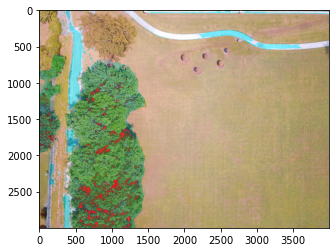

In [ ]:
# Visualization of the prediction result
import cv2
import matplotlib.pyplot as plt
import numpy as np

name = 10184 #10184,6414,6447,6499

# original RGB image
image = plt.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/rasters/raw/{name}.tif')

# binary mask
mask = plt.imread(f'/content/drive/MyDrive/Colab Notebooks/Deep learning/Project/Hurricane_Harvey/test_pred_sub/{name}.png')

# Create a 3 channel image with mask and original image
overlay = np.zeros_like(image)
overlay[:,:,0] = mask*255/26*255
overlay = overlay + image

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Display the mask on top of the image with 50% transparency
ax.imshow(overlay)

# Show the plot
plt.show()

In [ ]:
# Check the output shape, if it is successfully recovered into original shape
import tarfile
import numpy as np
import cv2

# Open the tar file
with tarfile.open('/content/submission.tar', 'r') as tar:
    # Iterate over the members (files and directories) in the tar file
    for member in tar.getmembers():
        # Check if the member is a file and if its name ends with '.png'
        if member.isfile() and member.name.endswith('.png'):
            # Extract the member to a memory buffer
            f = tar.extractfile(member)
            # Read the image from the memory buffer
            image = np.frombuffer(f.read(), np.uint8)
            # Decode the image
            image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
            # Print the shape of the image
            print(f'{member.name} - {image.shape}')


6456.png - (3000, 4000)
6414.png - (3000, 4000)
10300.png - (3000, 4000)
6447.png - (3000, 4000)
10184.png - (3000, 4000)
6427.png - (3000, 4000)
6645.png - (3000, 4000)
6580.png - (3072, 4592)
6574.png - (3072, 4592)
6649.png - (3000, 4000)
6608.png - (3072, 4592)
6659.png - (3000, 4000)
6569.png - (3000, 4000)
6691.png - (3072, 4592)
6603.png - (3072, 4592)
6469.png - (3000, 4000)
6715.png - (3072, 4592)
6548.png - (3000, 4000)
6703.png - (3000, 4000)
6796.png - (3000, 4000)
6829.png - (3000, 4000)
6794.png - (3000, 4000)
6710.png - (3072, 4592)
6639.png - (3000, 4000)
6499.png - (3000, 4000)
6820.png - (3000, 4000)
6946.png - (3000, 4000)
6933.png - (3000, 4000)
7241.png - (3072, 4592)
6979.png - (3000, 4000)
7252.png - (3072, 4592)
6939.png - (3000, 4000)
7298.png - (3000, 4000)
7258.png - (3072, 4592)
7310.png - (3072, 4592)
7301.png - (3072, 4592)
7318.png - (3072, 4592)
7306.png - (3072, 4592)
7320.png - (3072, 4592)
7245.png - (3072, 4592)
7305.png - (3072, 4592)
7415.png - (30

# Alternative thoughts

In [ ]:
# Alternative solutions: We may use GAN to address the problem
import torch
import torch.nn as nn
import torch.optim as optim

# Define your generator and discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # define your generator architecture
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # define your discriminator architecture
        
# Define your loss function
criterion = nn.BCELoss()

# Define your optimizers
G_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
D_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Train the GAN
for epoch in range(num_epochs):
    for i, (real_data, real_label) in enumerate(train_loader):
        # Train the discriminator
        D_optimizer.zero_grad()
        
        # Generate synthetic data
        noise = torch.randn(batch_size, noise_dim)
        synthetic_data = generator(noise)
        
        # Compute the loss for the discriminator
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
        synthetic_loss = criterion(discriminator(synthetic_data), torch.zeros(batch_size, 1))
        D_loss = real_loss + synthetic_loss
        
        D_loss.backward()
        D_optimizer.step()
        
        # Train the generator
        G_optimizer.zero_grad()
        
        # Compute the loss for the generator
        G_loss = criterion(discriminator(synthetic_data), torch.ones(batch_size, 1))
        
        G_loss.backward()
        G_optimizer.step()
        
    # Print the loss every few epochs
    if (epoch+1) % print_interval == 0:
        print("Epoch {}: D_loss: {:.4f}, G_loss: {:.4f}".format(epoch+1, D_loss.item(), G_loss.item()))

In [ ]:
#Need to debug
def dicescore(output, mask):
    import numpy as np

    num_classes = 27
    batch_size = output.shape[0]
    dice_scores = np.zeros((num_classes,))
    mask = mask.cpu().numpy().astype(int)
    output = output.cpu().detach().numpy()

    # Find the predicted class for each image in the batch
    predicted_class = np.argmax(output, axis=1)

    for i in range(num_classes):
        class_mask = (mask == i).astype(np.float32)
        predicted_class_mask = np.zeros_like(class_mask)
        for j in range(batch_size):
            predicted_class_mask[j] = np.where(predicted_class[j] == i, class_mask[j], 0)
        intersection = np.sum(predicted_class_mask)
        union = np.sum(class_mask) + np.sum(predicted_class_mask)
        intersection[np.isnan(intersection)] = 0
        union[np.isnan(union)] = 0
        dice_scores[i] = 2 * intersection / union
    class_names = {
        0: "None",
        1: "Property Roof",
        2: "Secondary Structure",
        3: "Swimming Pool",
        4: "Vehicle",
        5: "Grass",
        6: "Trees / Shrubs",
        7: "Solar Panels",
        8: "Chimney",
        9: "Street Light",
        10: "Window",
        11: "Satellite Antenna",
        12: "Garbage Bins",
        13: "Trampoline",
        14: "Road / Highway",
        15: "Under Construction / In Progress Status",
        16: "Power Lines & Cables",
        17: "Bridge",
        18: "Water Tank / Oil Tank",
        19: "Parking Area - Commercial",
        20: "Sports Complex / Arena",
        21: "Industrial Site",
        22: "Dense Vegetation / Forest",
        23: "Water Body",
        24: "Flooded",
        25: "Boat",
        26: "Parking Area"
    }

    classes_scores = {}
    for i in range(num_classes):
        classes_scores[class_names[i]] = dice_scores[i]

    return dice_scores, classes_scores
#This will output an array of Dice scores, one for each class. The value of Dice score ranges from 0 to 1. A dice score of 1 represents perfect overlap between the output and mask.


In [ ]:
# Calculate the accuracy
#Validation
model.eval()
train_running_correct = []


#Iterate through validation batches
for i, batch, in enumerate(tqdm(val_dataloader)):
    img_batch, lbl_batch = batch

    #Transfer images and masks to GPU
    img_batch = img_batch.to(device)
    lbl_batch = lbl_batch.to(device)

    #Compute output
    outputs=model(img_batch.float())
    
    #Compute loss
    loss=criterion(outputs, lbl_batch.long())
    # Calculate the accuracy.
    accuracy, _ = dicescore(outputs, lbl_batch.long())
    train_running_correct.append(accuracy)
epoch_acc = np.mean(train_running_correct)
print(epoch_acc)

In [ ]:
# Hyperparameter tuning
! pip install ray
! pip install -U tensorboardx

In [ ]:
# Tuning the hyperparameters using the library ray

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


# Training function.
def train(model, train_dataloader, optimizer, criterion, device):
  model.train()
  print("Training...")
  train_running_loss = 0.0
  train_running_correct = []
  counter = 0
  for i, batch, in enumerate(tqdm(train_dataloader)):
      counter += 1
      img_batch, lbl_batch = batch

      #Transfer images and masks to GPU
      img_batch = img_batch.to(device)
      lbl_batch = lbl_batch.to(device)
      optimizer.zero_grad()
      #Compute output
      outputs = model(img_batch.float())
      
      #Compute loss
      loss=criterion(outputs, lbl_batch.long()) 
      train_running_loss += loss.item()
      # Calculate the accuracy.
      accuracy, _ = dicescore(outputs, lbl_batch.long())
      train_running_correct.append(accuracy)
      # Backpropagation.
      loss.backward()
      # Update the optimizer parameters.
      optimizer.step()

  # Loss and accuracy for the complete epoch.
  epoch_loss = train_running_loss / counter
  epoch_acc = np.mean(train_running_correct)
  return epoch_loss, epoch_acc

# Validation function.
def validate(model, val_dataloader, criterion, device):
    model.eval()
    print('Validating...')
    valid_running_loss = 0.0
    valid_running_correct = []
    counter = 0
    
    with torch.no_grad():
        for i, batch, in enumerate(tqdm(val_dataloader)):
            counter += 1
            img_batch, lbl_batch = batch

            #Transfer images and masks to GPU
            img_batch = img_batch.to(device)
            lbl_batch = lbl_batch.to(device)
            
            #Compute output
            outputs=model(img_batch.float())
            
            #Compute loss
            loss=criterion(outputs, lbl_batch.long())
            val_losses+ = loss.item()
            # Calculate the accuracy.
            accuracy, _ = dicescore(outputs, target)
            valid_running_correct.append(accuracy)


    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)
      
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = np.mean(valid_running_correct)
    return epoch_loss, epoch_acc


In [ ]:
import os

def train_and_validate(config):
    # Get training and validation data loaders,
    # ignore test data loader for now.

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Prepare the data
    mask_datadir = "/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"
    image_datadir = "/content/drive/MyDrive/Hurricane_Harvey/rasters/raw"
    metatraindir = "/content/drive/MyDrive/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv"
    labeled_listpd = pd.read_csv(metatraindir)
    labeled_list = labeled_listpd["image:01"].map(lambda x:x.split("/")[-1]).tolist()
    arr = np.array(labeled_list)
    labeled_list = np.unique(arr)
    dataset = datatran(mask_datadir,image_datadir,labeled_list)
    data_batch = trainbatch(dataset)
    train_dataloader, val_dataloader = valsplit(data_batch)
    # Initialize the model
    n_classes = 27
    model = ResNetUNet(n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"] , weight_decay=config["weight_decay"])  
    criterion = nn.CrossEntropyLoss()
    epochs = 15

    path = '/content/drive/MyDrive/Hurricane_Harvey/model0122.pt'
    # start the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(
            model, train_dataloader, optimizer, criterion, device
        )
        valid_epoch_loss, valid_epoch_acc = validate(
            model, val_dataloader, criterion, device
        )
  
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        tune.report(
            loss=valid_epoch_loss, accuracy=valid_epoch_acc
        )

In [ ]:
def run_search(device):
    # Define the parameter search configuration.
    config={
    "lr": tune.loguniform(1e-4,1e-3),
    "weight_decay": tune.loguniform(0.0001,0.001)
    }
    # Schduler to stop bad performing trails.
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=1,
        reduction_factor=2)

    # Reporter to show on command line/output window
    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    # Start run/search
    result = tune.run(
        train_and_validate,
        resources_per_trial={"cpu": 2, "gpu": 1},
        config=config,
        scheduler=scheduler,
        local_dir='raytune_result',
        keep_checkpoints_num=1,
        checkpoint_score_attr='min-validation_loss',
        progress_reporter=reporter,
        num_samples=10
    )

    # Extract the best trial run from the search.
    best_trial = result.get_best_trial(
        'accuracy', 'max', 'last'
    )
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation acc: {best_trial.last_result['accuracy']}")
    return best_trial


In [ ]:
best_trial = run_search(device)

In [ ]:
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation acc: {best_trial.last_result['accuracy']}")

In [ ]:
# The codes below require large memory storage
#Define sizes for images and patches
def shiftrgb(im):
    # Shift the RGB values
    rgb_shift = (10, 20, 30) # shift values for each channel
    im[:, :, 0] += rgb_shift[0] # R channel
    im[:, :, 1] += rgb_shift[1] # G channel
    im[:, :, 2] += rgb_shift[2] # B channel

    # Clipping the values of image array after shift
    im = np.clip(im, 0, 255).astype("uint8")
    return im

# By doing the patching, actually lost information
def datatran(mask_datadir,image_datadir,labeled_list):
    img_size = 1024, 1024  #1024 When I tried to use 1024, the RAM exploded. 
    mask_size = 1024, 1024
    img_patch_size = 512 #256
    mask_patch_size = 512

    from tqdm import tqdm

    #Image transformations, adapted to the transformations originally used to train ResNet
    transform_img = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

    #Transformations for training masks
    transform_mask = transforms.Compose([transforms.ToTensor()])

    #Define directories
    directory_names = [mask_datadir,image_datadir]
    dataset = []

    #Number of classes
    n_classes = 27 # the classes are 26, but 0 for nothing

    #Iterate through every directory
    for name in directory_names:
      directory = os.fsencode(name)
      list_tensors = []
      #Iterate every file 
      for file in tqdm(sorted(os.listdir(directory))):
        filename = os.fsdecode(file)
        #Pre-processing for training masks
        if name == mask_datadir:
          #Load image
          im = cv2.imread(name + '/' + filename, cv2.IMREAD_GRAYSCALE)
          #Convert to np array
          im = np.array(im, dtype='i')
          #Resize for patchifying
          im = cv2.resize(im, dsize= mask_size,interpolation = cv2.INTER_NEAREST)
          #Store original image at smaller size waiting for later data augmentation processing
          im_og = cv2.resize(im, dsize= (mask_patch_size,mask_patch_size),interpolation = cv2.INTER_NEAREST)
          #Patchify image and store patches in list
          patches_img = patchify(im, (mask_patch_size, mask_patch_size), step=mask_patch_size)
          #Can conceal the following codes in a function to avoid repeating
          #Remove dimension        
          patches_img = patches_img.squeeze()
          #Iterate through all patches
          for i in range(2):
            for j in range(2):
              #Define patch
              im = patches_img[i,j,:,:]
              #Apply transformations to generate several versions of patch (RGB shift & flipping & rotations)
              im_list = [im, im, np.flip(im,axis=0).copy(), np.rot90(im, k=1, axes=(0, 1)).copy()]
              #Iterate through different versions
              for im in im_list:
                #Apply mask transformations
                if name == mask_datadir:
                  tensor_img = transform_mask(im)
                  tensor_img = tensor_img.squeeze()
                #Apply image transformations
                else:
                  tensor_img = transform_img(im.astype(np.float32))
                #Append tensor to list
                list_tensors.append(tensor_img.type(torch.FloatTensor))
              
        #Pre-processing for images
        elif filename in labeled_list:
          #Load image
          im = cv2.imread(name + '/' + filename)
          #Convert to np array
          im = np.array(im)
          #Resize for patchifying
          im = cv2.resize(im, dsize= img_size,interpolation = cv2.INTER_NEAREST)
          #Store original image at smaller size waiting for later data augmentation processing
          im_og = cv2.resize(im, dsize= (img_patch_size,img_patch_size),interpolation = cv2.INTER_NEAREST)
          #Patchify image and store patches in list
          patches_img = patchify(im, (img_patch_size, img_patch_size, 3), step=mask_patch_size)

          #Remove dimension        
          patches_img = patches_img.squeeze()
          #Iterate through all patches
          for i in range(2):
            for j in range(2):
              #Define patch
              im = patches_img[i,j,:,:]
              #Apply transformations to generate several versions of patch (flipping & rotations)
              im_list = [im, shiftrgb(im), np.flip(im,axis=0).copy(), np.rot90(im, k=1, axes=(0, 1)).copy()]
              #Iterate through different versions
              for im in im_list:
                #Apply mask transformations
                if name == mask_datadir:
                  tensor_img = transform_mask(im)
                  tensor_img = tensor_img.squeeze()
                #Apply image transformations
                else:
                  tensor_img = transform_img(im.astype(np.float32))
                #Append tensor to list
                list_tensors.append(tensor_img.type(torch.FloatTensor))
      
        #Apply transformations to generate several versions of original image
        im_list = [im_og, np.flip(im_og,axis=0).copy()]
        #Iterate through different versions
        for im in im_list:
          #Apply mask transformations
          if name == mask_datadir:
            tensor_img = transform_mask(im)
            tensor_img = tensor_img.squeeze()
            #Append tensor to list
            list_tensors.append(tensor_img.type(torch.FloatTensor))
          #Apply image transformations
          elif filename in labeled_list:
            tensor_img = transform_img(im)
            #Append tensor to list
            list_tensors.append(tensor_img.type(torch.FloatTensor))
      #Append list of tensors as element in dataset
      dataset.append(list_tensors)
    return dataset